In [ ]:
### GPU configuration
! nvidia-smi

Sun Jan  7 13:18:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0              32W /  70W |   1157MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import time
st=time.time()

In [ ]:
!pip install tensorflow_addons

In [ ]:
!pip install visualkeras

In [ ]:
import cv2
import numpy as np
import glob
import os

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

In [ ]:
from matplotlib import pyplot as plt


In [ ]:
labels = ["CuttingCaterpillar", "CuttingWeevil", "DieBack", "Healthy", "WhiteFly","Yellow"]
img_size = 48
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
data_dir = get_data("/content/drive/MyDrive/Thesis/Soursop")

<ipython-input-50-7f7624e5cd11>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
X = []
Y = []

for feature, label in data_dir:
  X.append(feature)
  Y.append(label)
X = np.array(X) / 255
X.reshape(-1, img_size, img_size, 1)
Y = np.array(Y)

In [ ]:
print(X.shape)
print(Y.shape)

(3890, 48, 48, 3)
(3890,)


In [ ]:
# split with a stratified sampling
from sklearn.model_selection import train_test_split
(x_train, x_test, y_train, y_test) = train_test_split(X, Y, test_size=0.10, stratify=Y, random_state=42)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
    test_size=0.18, random_state= 8) # 0.25 x 0.8 = 0.2

In [ ]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (2870, 48, 48, 3) - y_train shape: (2870,)
x_val shape: (631, 48, 48, 3) - y_val shape: (631,)
x_test shape: (389, 48, 48, 3) - y_test shape: (389,)


In [ ]:
y_train = keras.utils.to_categorical(y_train, num_classes=6, dtype='float32')
y_val = keras.utils.to_categorical(y_val, num_classes=6, dtype='float32')
y_test = keras.utils.to_categorical(y_test, num_classes=6, dtype='float32')


In [ ]:
num_classes = 6
input_shape = (48, 48, 3)

In [ ]:
weight_decay = 0.0001
learning_rate = 0.001
label_smoothing = 0.1
validation_split = 0.2
batch_size = 128
num_epochs = 250
image_size=48
patch_size = 6  # Size of the patches to be extracted from the input images.
num_patches = (image_size // patch_size) ** 2  # Number of patch
embedding_dim = 128  # Number of hidden units.
mlp_dim = 64
dim_coefficient = 4
num_heads = 2
attention_dropout = 0.2
projection_dropout = 0.2
num_transformer_blocks = 8  # Number of repetitions of the transformer layer

print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")

Patch size: 6 X 6 = 36 
Patches per image: 64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size, self.patch_size, 1),
            strides=(1, self.patch_size, self.patch_size, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)

In [ ]:
def external_attention(
    x, dim, num_heads, dim_coefficient=4, attention_dropout=0.0, projection_dropout=0.0
):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = tf.reshape(
        x, shape=(-1, num_patch, num_heads, dim * dim_coefficient // num_heads)
    )
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    # a linear layer M_k
    attn = layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = attn / (1e-9 + tf.reduce_sum(attn, axis=-1, keepdims=True))
    attn = layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    x = tf.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = layers.Dense(dim)(x)
    x = layers.Dropout(projection_dropout)(x)
    return x

In [ ]:
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = layers.Dense(mlp_dim, activation=tf.nn.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x

In [ ]:
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="external_attention",
):
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    if attention_type == "external_attention":
        x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    elif attention_type == "self_attention":
        x = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim, dropout=attention_dropout
        )(x, x)
    x = layers.add([x, residual_1])
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    return x

In [ ]:
def get_model(attention_type="external_attention"):
    inputs = layers.Input(shape=input_shape)
    # Image augment
    x = data_augmentation(inputs)
    # Extract patches.
    x = PatchExtract(patch_size)(x)
    # Create patch embedding.
    x = PatchEmbedding(num_patches, embedding_dim)(x)
    # Create Transformer block.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(
            x,
            embedding_dim,
            mlp_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
            attention_type,
        )

    x = layers.GlobalAvgPool1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = get_model(attention_type="external_attention")

model.compile(loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,name="Adam"),
    metrics=[keras.metrics.CategoricalAccuracy(name="accuracy"), keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy")]) #, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
checkpoint_filepath = "/content/drive/MyDrive/model48.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor="val_accuracy", save_best_only=True, save_weights_only=True,
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, cooldown= 10, patience=10, verbose =1, min_lr=0.1e-7),


# stop learining as metric on validatopn stop increasing
early_stopping = tf.keras.callbacks.EarlyStopping(patience=15, verbose=1, mode = 'auto'))


history = model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=validation_split,)

Epoch 1/250
18/18 [==============================] - 49s 252ms/step - loss: 2.5328 - accuracy: 0.2343 - top-5-accuracy: 0.8824 - val_loss: 1.8524 - val_accuracy: 0.4199 - val_top-5-accuracy: 0.9303
Epoch 2/250
18/18 [==============================] - 2s 122ms/step - loss: 1.5402 - accuracy: 0.4003 - top-5-accuracy: 0.9704 - val_loss: 1.8667 - val_accuracy: 0.4355 - val_top-5-accuracy: 0.9512
Epoch 3/250
18/18 [==============================] - 2s 123ms/step - loss: 1.3487 - accuracy: 0.5179 - top-5-accuracy: 0.9826 - val_loss: 1.8493 - val_accuracy: 0.3780 - val_top-5-accuracy: 0.9739
Epoch 4/250
18/18 [==============================] - 2s 122ms/step - loss: 1.2122 - accuracy: 0.5884 - top-5-accuracy: 0.9930 - val_loss: 1.4504 - val_accuracy: 0.5314 - val_top-5-accuracy: 0.9861
Epoch 5/250
18/18 [==============================] - 2s 131ms/step - loss: 1.0759 - accuracy: 0.6760 - top-5-accuracy: 0.9930 - val_loss: 1.4178 - val_accuracy: 0.4564 - val_top-5-accuracy: 0.9948
Epoch 6/250
18

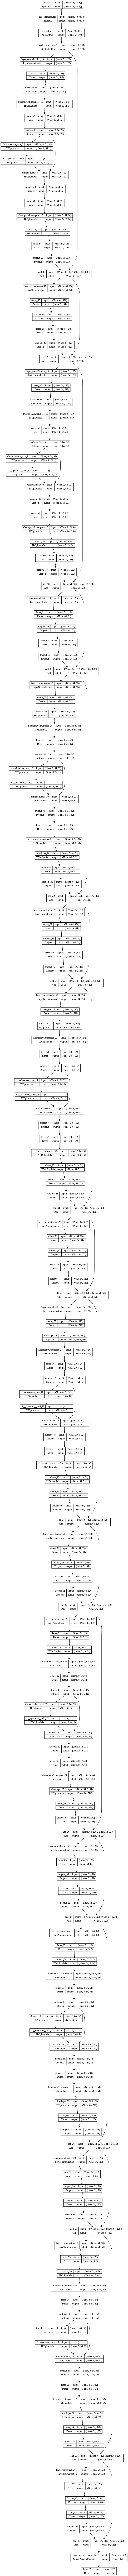

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [ ]:
loss = history.history.get('loss')
accuracy = history.history.get('accuracy')

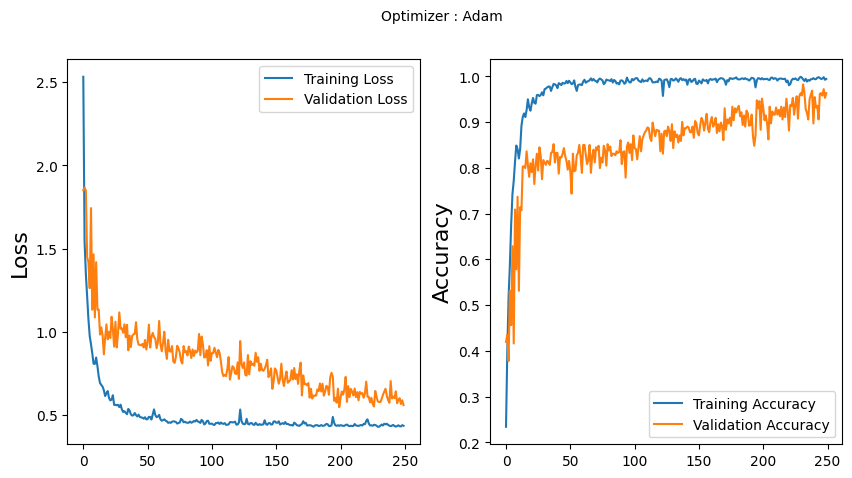

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (2870, 48, 48, 3) - y_train shape: (2870, 6)
x_val shape: (631, 48, 48, 3) - y_val shape: (631, 6)
x_test shape: (389, 48, 48, 3) - y_test shape: (389, 6)


In [ ]:
vit_predictions = model.predict(x_val)
vit_y_pred = [np.argmax(probas) for probas in vit_predictions]

20/20 [==============================] - 3s 41ms/step


In [ ]:
import itertools

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f%' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 86   0   1   0   0   0]
 [  4  97   0  20   2   0]
 [  2   0  97   0   0   0]
 [  0   2   0  89   0   0]
 [  0   0   0   0 123   0]
 [  0   0   4   0   2 102]]


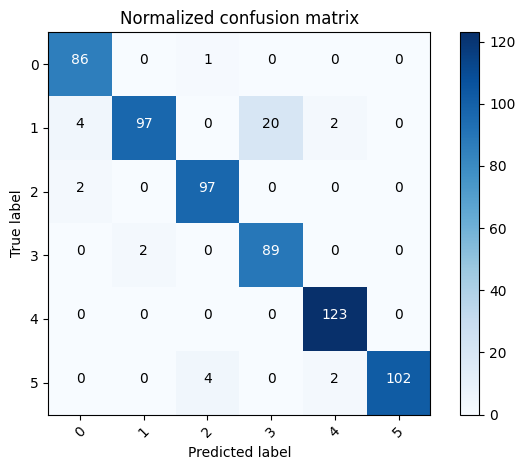

In [ ]:
# compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(y_val,axis=1), vit_y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["0", "1", "2", "3", "4","5"], title='Normalized confusion matrix')
plt.show()

In [ ]:
print(classification_report(np.argmax(y_val,axis=1), vit_y_pred, target_names=["0", "1", "2", "3", "4","5"]))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96        87
           1       0.98      0.79      0.87       123
           2       0.95      0.98      0.97        99
           3       0.82      0.98      0.89        91
           4       0.97      1.00      0.98       123
           5       1.00      0.94      0.97       108

    accuracy                           0.94       631
   macro avg       0.94      0.95      0.94       631
weighted avg       0.95      0.94      0.94       631



In [ ]:
vit_predictions = model.predict(x_test)
vit_y_pred = [np.argmax(probas) for probas in vit_predictions]

13/13 [==============================] - 1s 42ms/step


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f%' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[63  0  1  0  0  0]
 [ 2 55  1  7  1  0]
 [ 0  0 65  0  0  0]
 [ 0  2  0 64  0  0]
 [ 0  0  0  0 65  0]
 [ 0  0  1  0  0 62]]


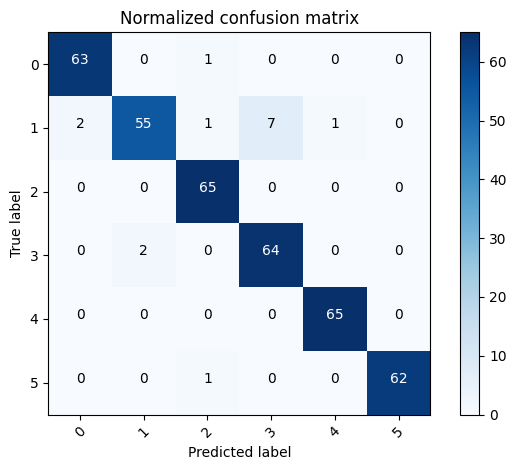

In [ ]:
# compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(y_test,axis=1), vit_y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["0", "1", "2", "3", "4","5"], title='Normalized confusion matrix')
plt.show()

In [ ]:
print(classification_report(np.argmax(y_test,axis=1), vit_y_pred, target_names=["0", "1", "2", "3", "4","5"]))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98        64
           1       0.96      0.83      0.89        66
           2       0.96      1.00      0.98        65
           3       0.90      0.97      0.93        66
           4       0.98      1.00      0.99        65
           5       1.00      0.98      0.99        63

    accuracy                           0.96       389
   macro avg       0.96      0.96      0.96       389
weighted avg       0.96      0.96      0.96       389



In [ ]:
et=time.time()
et=et-st
print(f"Execution time:{et}s")

Execution time:705.3635566234589s
